In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense , Dropout
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
plt.style.use('fivethirtyeight')

In [2]:
# Load data
data = pd.read_csv("data/AAPL_use.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-10-30,6.649286,6.763214,6.597500,6.678571,5.668749,939414000
1,2007-10-31,6.701071,6.790000,6.605357,6.783929,5.758174,833310800
2,2007-11-01,6.735714,6.789286,6.428571,6.694286,5.682087,805036400
3,2007-11-02,6.757500,6.765714,6.553214,6.709643,5.695121,1002114400
4,2007-11-05,6.617500,6.748571,6.580000,6.649286,5.643891,804176800
...,...,...,...,...,...,...,...
4022,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100
4023,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600
4024,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000
4025,2023-10-26,170.369995,171.380005,165.669998,166.889999,166.889999,70625300


In [3]:
# Removing %h-%m-%s From Date Column
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%d-%m-%Y')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,30-10-2007,6.649286,6.763214,6.597500,6.678571,5.668749,939414000
1,31-10-2007,6.701071,6.790000,6.605357,6.783929,5.758174,833310800
2,01-11-2007,6.735714,6.789286,6.428571,6.694286,5.682087,805036400
3,02-11-2007,6.757500,6.765714,6.553214,6.709643,5.695121,1002114400
4,05-11-2007,6.617500,6.748571,6.580000,6.649286,5.643891,804176800
...,...,...,...,...,...,...,...
4022,23-10-2023,170.910004,174.009995,169.929993,173.000000,173.000000,55980100
4023,24-10-2023,173.050003,173.669998,171.449997,173.440002,173.440002,43816600
4024,25-10-2023,171.880005,173.059998,170.649994,171.100006,171.100006,57157000
4025,26-10-2023,170.369995,171.380005,165.669998,166.889999,166.889999,70625300


In [4]:
# Checking The Type Of Data Column(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4027 non-null   object 
 1   Open       4027 non-null   float64
 2   High       4027 non-null   float64
 3   Low        4027 non-null   float64
 4   Close      4027 non-null   float64
 5   Adj Close  4027 non-null   float64
 6   Volume     4027 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 220.4+ KB


In [5]:
# Converting Object To Datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-10-30,6.649286,6.763214,6.597500,6.678571,5.668749,939414000
1,2007-10-31,6.701071,6.790000,6.605357,6.783929,5.758174,833310800
2,2007-11-01,6.735714,6.789286,6.428571,6.694286,5.682087,805036400
3,2007-11-02,6.757500,6.765714,6.553214,6.709643,5.695121,1002114400
4,2007-11-05,6.617500,6.748571,6.580000,6.649286,5.643891,804176800
...,...,...,...,...,...,...,...
4022,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100
4023,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600
4024,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000
4025,2023-10-26,170.369995,171.380005,165.669998,166.889999,166.889999,70625300


In [6]:
# Checking The Type Of Data Column(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4027 non-null   datetime64[ns]
 1   Open       4027 non-null   float64       
 2   High       4027 non-null   float64       
 3   Low        4027 non-null   float64       
 4   Close      4027 non-null   float64       
 5   Adj Close  4027 non-null   float64       
 6   Volume     4027 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 220.4 KB


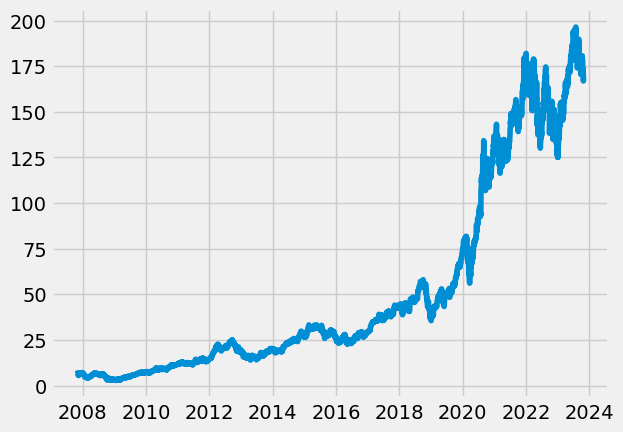

In [6]:
plt.plot(data['Date'],data['Close'])

In [7]:
data.shape

(4027, 7)

In [8]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data

array([[0.02006491],
       [0.02060896],
       [0.02014606],
       ...,
       [0.8690986 ],
       [0.84735911],
       [0.85422693]])

In [9]:
# Define input sequence length and target sequence length
sequence_length = 50 # Number of previous days to consider for prediction
target_length = 1  # Predicting only one day ahead 

In [10]:
# Create sequences
def create_sequences(data, sequence_length, target_length):
    X, y = [], [] 
    for i in range(len(data) - sequence_length - target_length):
        X.append(data[i:(i + sequence_length)]) # add without removing the previous data
        y.append(data[(i + sequence_length):(i + sequence_length + target_length)])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length, target_length)

In [11]:
# Reshape data for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# # Define the learning rate
# learning_rate = 0.001  

In [12]:
# Build CNN model
model = Sequential()
model.add(Conv1D(filters=64  
                 , kernel_size=3
                 , activation='relu', 
                 input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten()) 
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu')) # 50 neurons
model.add(Dense(target_length)) # one output layer

In [13]:
# Compile the model with specified learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['accuracy'])

# Train model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


100/100 [==============================] - 2s 11ms/step - loss: 8.9235e-04 - accuracy: 3.1447e-04 - val_loss: 0.0059 - val_accuracy: 0.0013
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 3.5567e-04 - accuracy: 3.1447e-04 - val_loss: 0.0078 - val_accuracy: 0.0013
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 2.6935e-04 - accuracy: 3.1447e-04 - val_loss: 0.0047 - val_accuracy: 0.0013
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 2.3579e-04 - accuracy: 3.1447e-04 - val_loss: 0.0017 - val_accuracy: 0.0013
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 2.3219e-04 - accuracy: 3.1447e-04 - val_loss: 0.0014 - val_accuracy: 0.0013
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 1.8908e-04 - accuracy: 3.1447e-04 - val_loss: 0.0020 - val_accuracy: 0.0013
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 1.9073e-04 - acc

Epoch 52/100
100/100 [==============================] - 1s 7ms/step - loss: 1.3344e-04 - accuracy: 3.1447e-04 - val_loss: 0.0053 - val_accuracy: 0.0013
Epoch 53/100
100/100 [==============================] - 1s 6ms/step - loss: 1.2355e-04 - accuracy: 3.1447e-04 - val_loss: 0.0086 - val_accuracy: 0.0013
Epoch 54/100
100/100 [==============================] - 1s 7ms/step - loss: 1.3807e-04 - accuracy: 3.1447e-04 - val_loss: 0.0055 - val_accuracy: 0.0013
Epoch 55/100
100/100 [==============================] - 1s 8ms/step - loss: 1.3385e-04 - accuracy: 3.1447e-04 - val_loss: 0.0026 - val_accuracy: 0.0013
Epoch 56/100
100/100 [==============================] - 1s 8ms/step - loss: 1.2971e-04 - accuracy: 3.1447e-04 - val_loss: 0.0141 - val_accuracy: 0.0013
Epoch 57/100
100/100 [==============================] - 1s 8ms/step - loss: 1.1820e-04 - accuracy: 3.1447e-04 - val_loss: 0.0107 - val_accuracy: 0.0013
Epoch 58/100
100/100 [==============================] - 1s 7ms/step - loss: 1.4630e-04 -

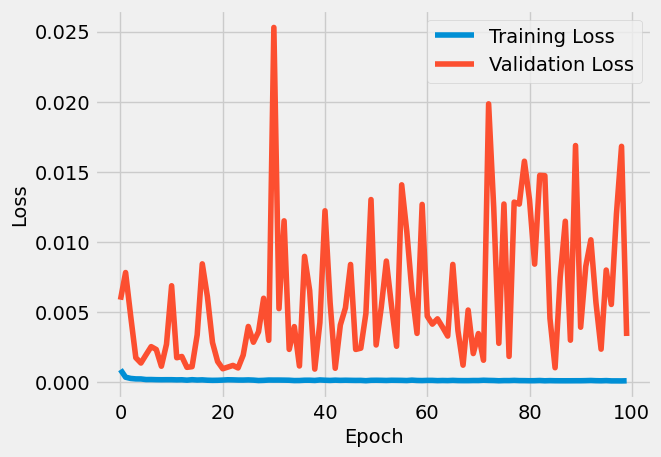

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# # Train model
# history =model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose=1)

# # Evaluate model
# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)
# print(f'Train Loss: {train_loss}')
# print(f'Test Loss: {test_loss}')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 50)                76850     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [16]:
# Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

25/25 [==============================] - 0s 3ms/step


In [17]:
# Calculate R2 score and MSE for training data
train_r2 = r2_score(y_train.reshape(-1), train_predictions.reshape(-1))
train_mse = mean_squared_error(y_train.reshape(-1), train_predictions.reshape(-1))

# Calculate R2 score and MSE for testing data
test_r2 = r2_score(y_test.reshape(-1), test_predictions.reshape(-1))
test_mse = mean_squared_error(y_test.reshape(-1), test_predictions.reshape(-1))

# Print evaluation metrics
print(f'Training R2 Score: {train_r2}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing R2 Score: {test_r2}')
print(f'Testing Mean Squared Error: {test_mse}')


Training R2 Score: 0.9826454602187974
Training Mean Squared Error: 0.00018829474965281526
Testing R2 Score: 0.713448622734308
Testing Mean Squared Error: 0.003295022804317429


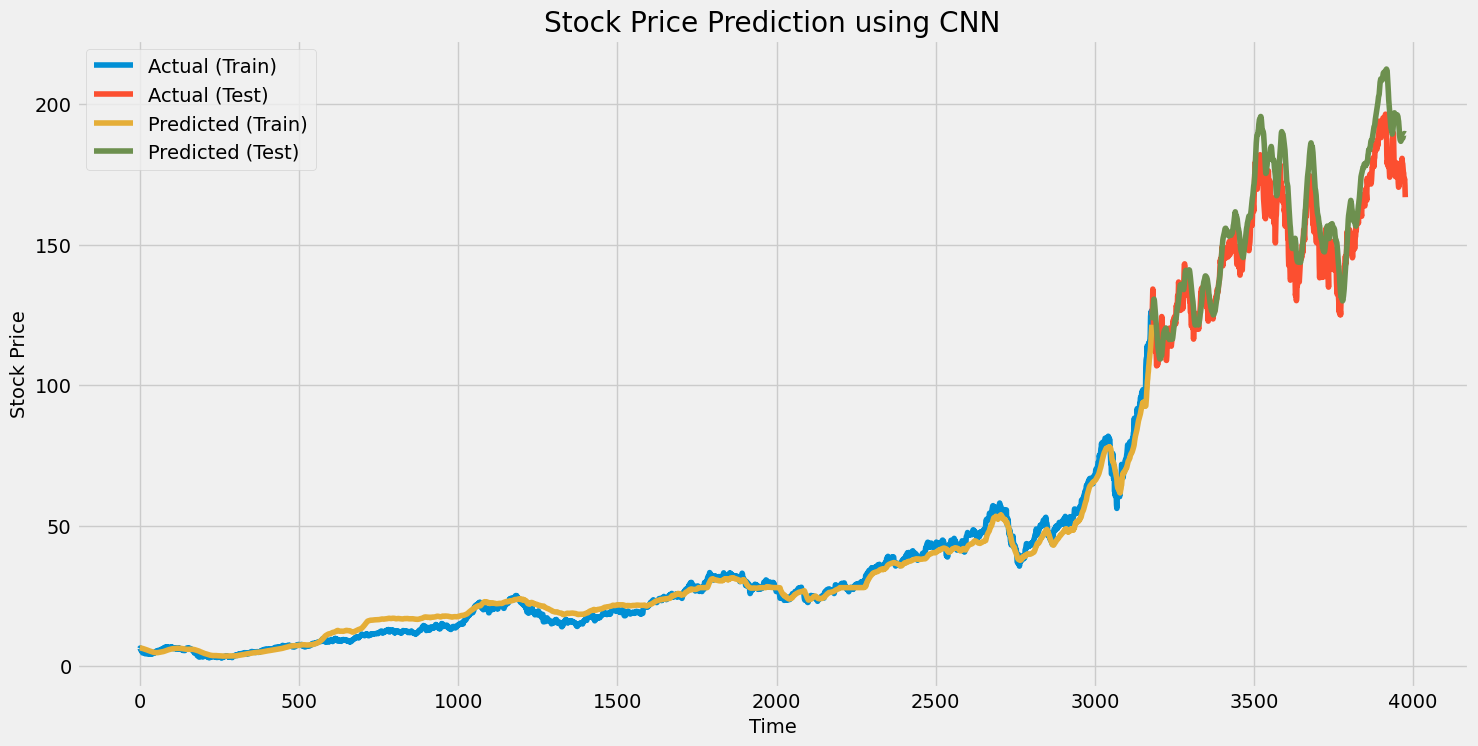

In [18]:
# Plot predictions
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()